<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/v0.8.0/05_qsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantum computing offers significant speedups for certain problems, with Quantum Support Vector Machines (QSVMs) emerging as a promising quantum-enhanced machine learning technique.

### 1. Background on SVMs

**SVM Objective:**

The goal of a Support Vector Machine (SVM) is to find a hyperplane that best separates data into different classes. Mathematically, we aim to maximize the margin between the two classes.

**Mathematical Formulation:**

In the original feature space, the decision boundary is given by:

$$
f(x) = w \cdot x + b
$$

where $w$ is the weight vector and $b$ is the bias term. The SVM optimization problem can be described as:

$$
\text{minimize } \frac{1}{2} \|w\|^2
$$

subject to:

$$
y_i (w \cdot x_i + b) \geq 1 \text{ for all } i
$$

### 2. The Kernel Trick

**Kernel Function:**

 If the classes are not linearly separable, the SVM can utilize kernel trick to map the non-linearly separable data into a higher-dimensional space, enabling linear classifiers to effectively classify complex datasets, This method leverages kernels or inner products of feature vectors for the transformation:

$$
K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)
$$

Kernel-based SVMs leverage kernel functions to project data into higher-dimensional spaces where linear separation is feasible (shown as the figure below), thus effectively handling complex, non-linear patterns without direct high-dimensional computations.

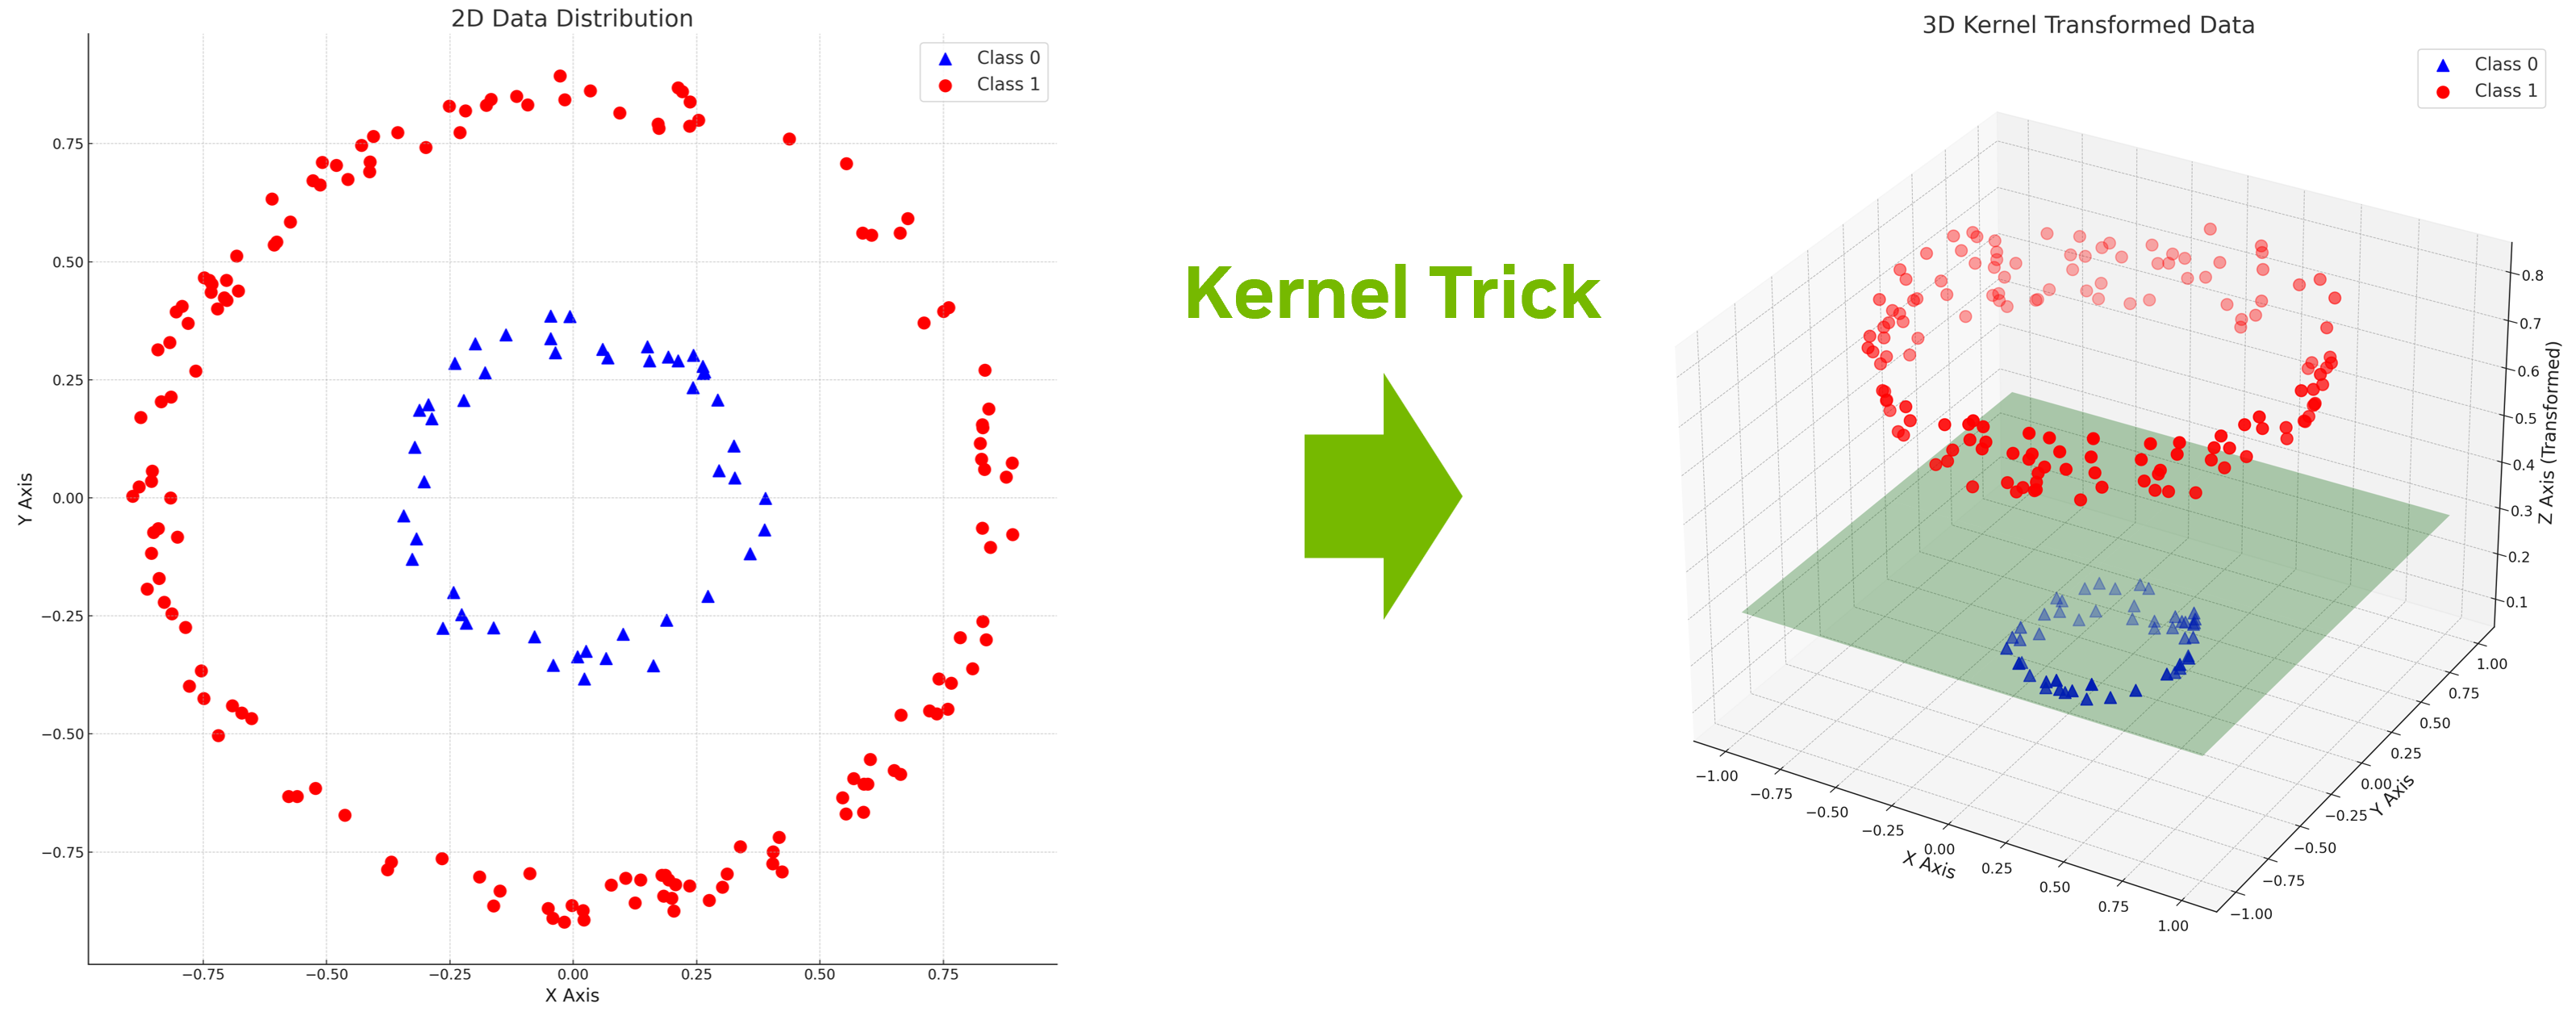

### 3. QSVM (Quantum Support Vector Machine)

**Quantum Kernel:**

In QSVMs, the measurement of a quantum circuit calculates the inner product in a high-dimensional space that is accessible through quantum gates, without the need for explicit transformation, The quantum kernel function can be represented as:

$$
K(x_i, x_j) = \langle \phi(x_i) | \phi(x_j) \rangle
$$


where the quantum states $|\phi(x)\rangle$ encode the features of the data $x$. These states can be prepared by applying a sequence of unitary gates $|U(x)\rangle$ to an initial quantum state. In this example, we use Block-Encoded State (BPS) wavefunctions as our quantum data encoding:



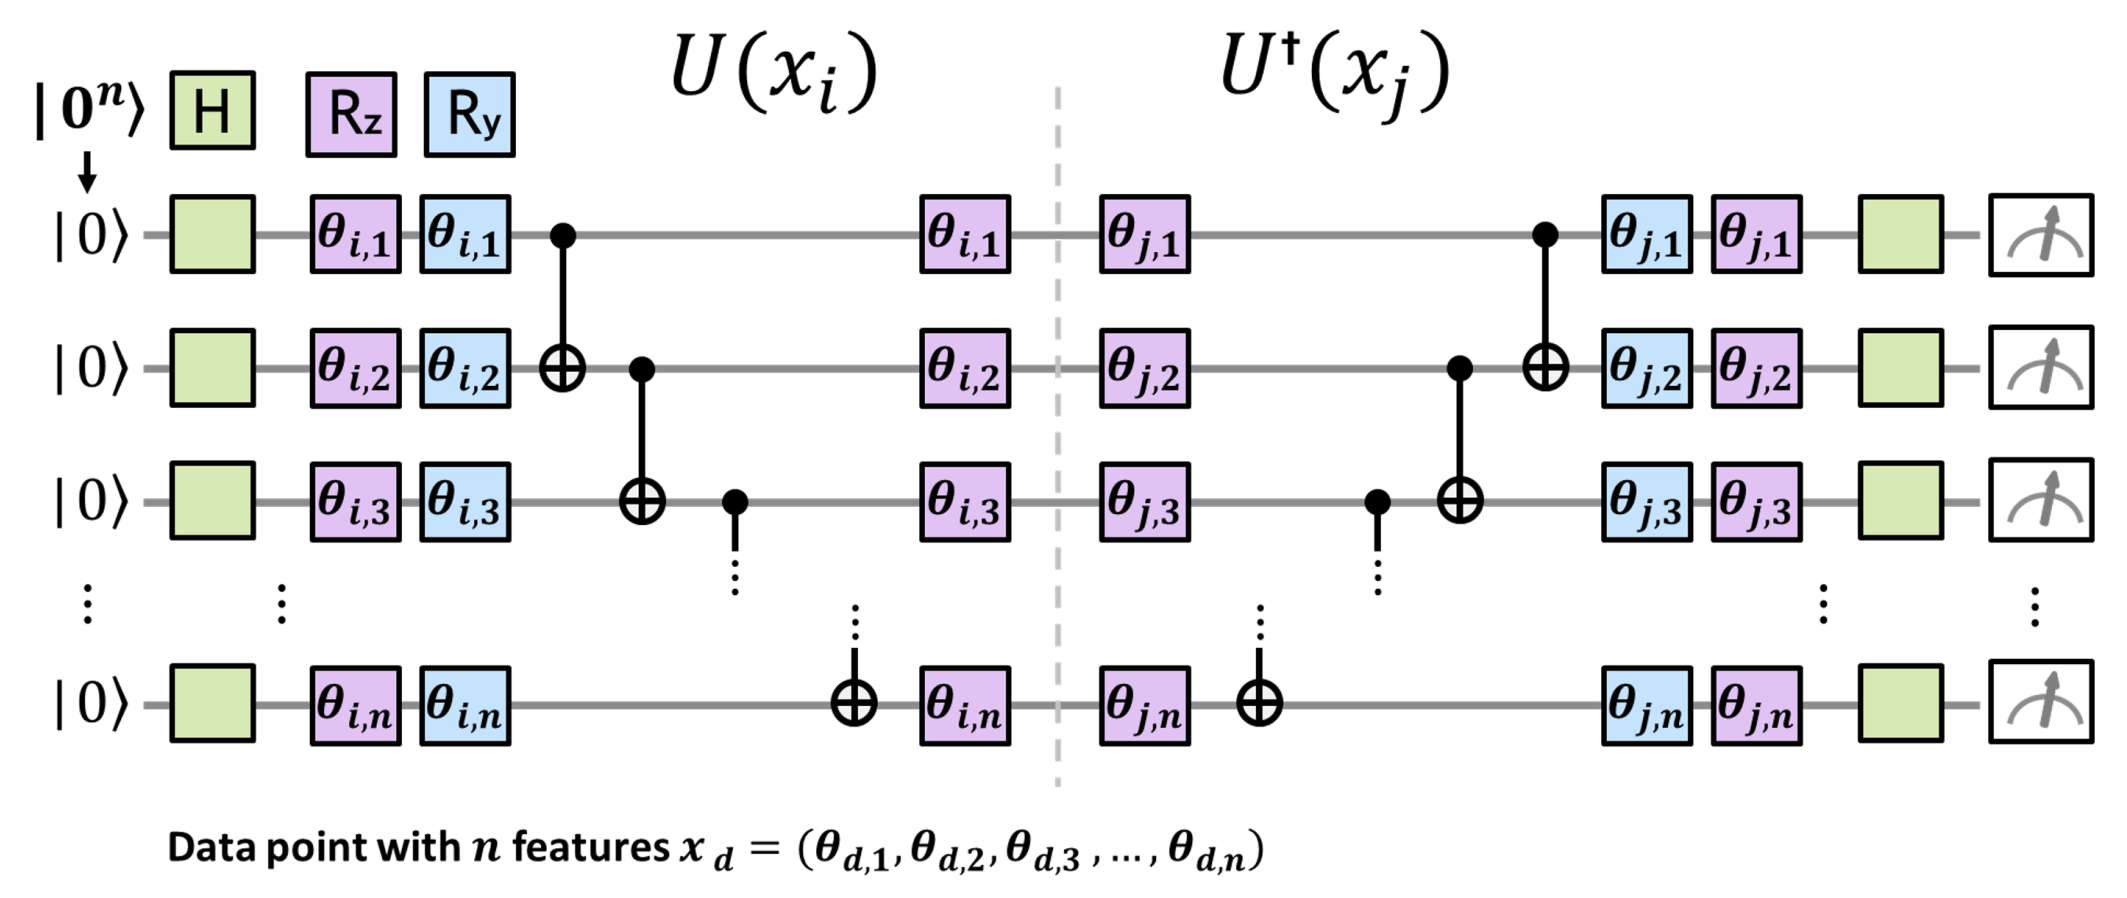

### 4. QSVM Workflow Accelerated by NVIDIA Quantum

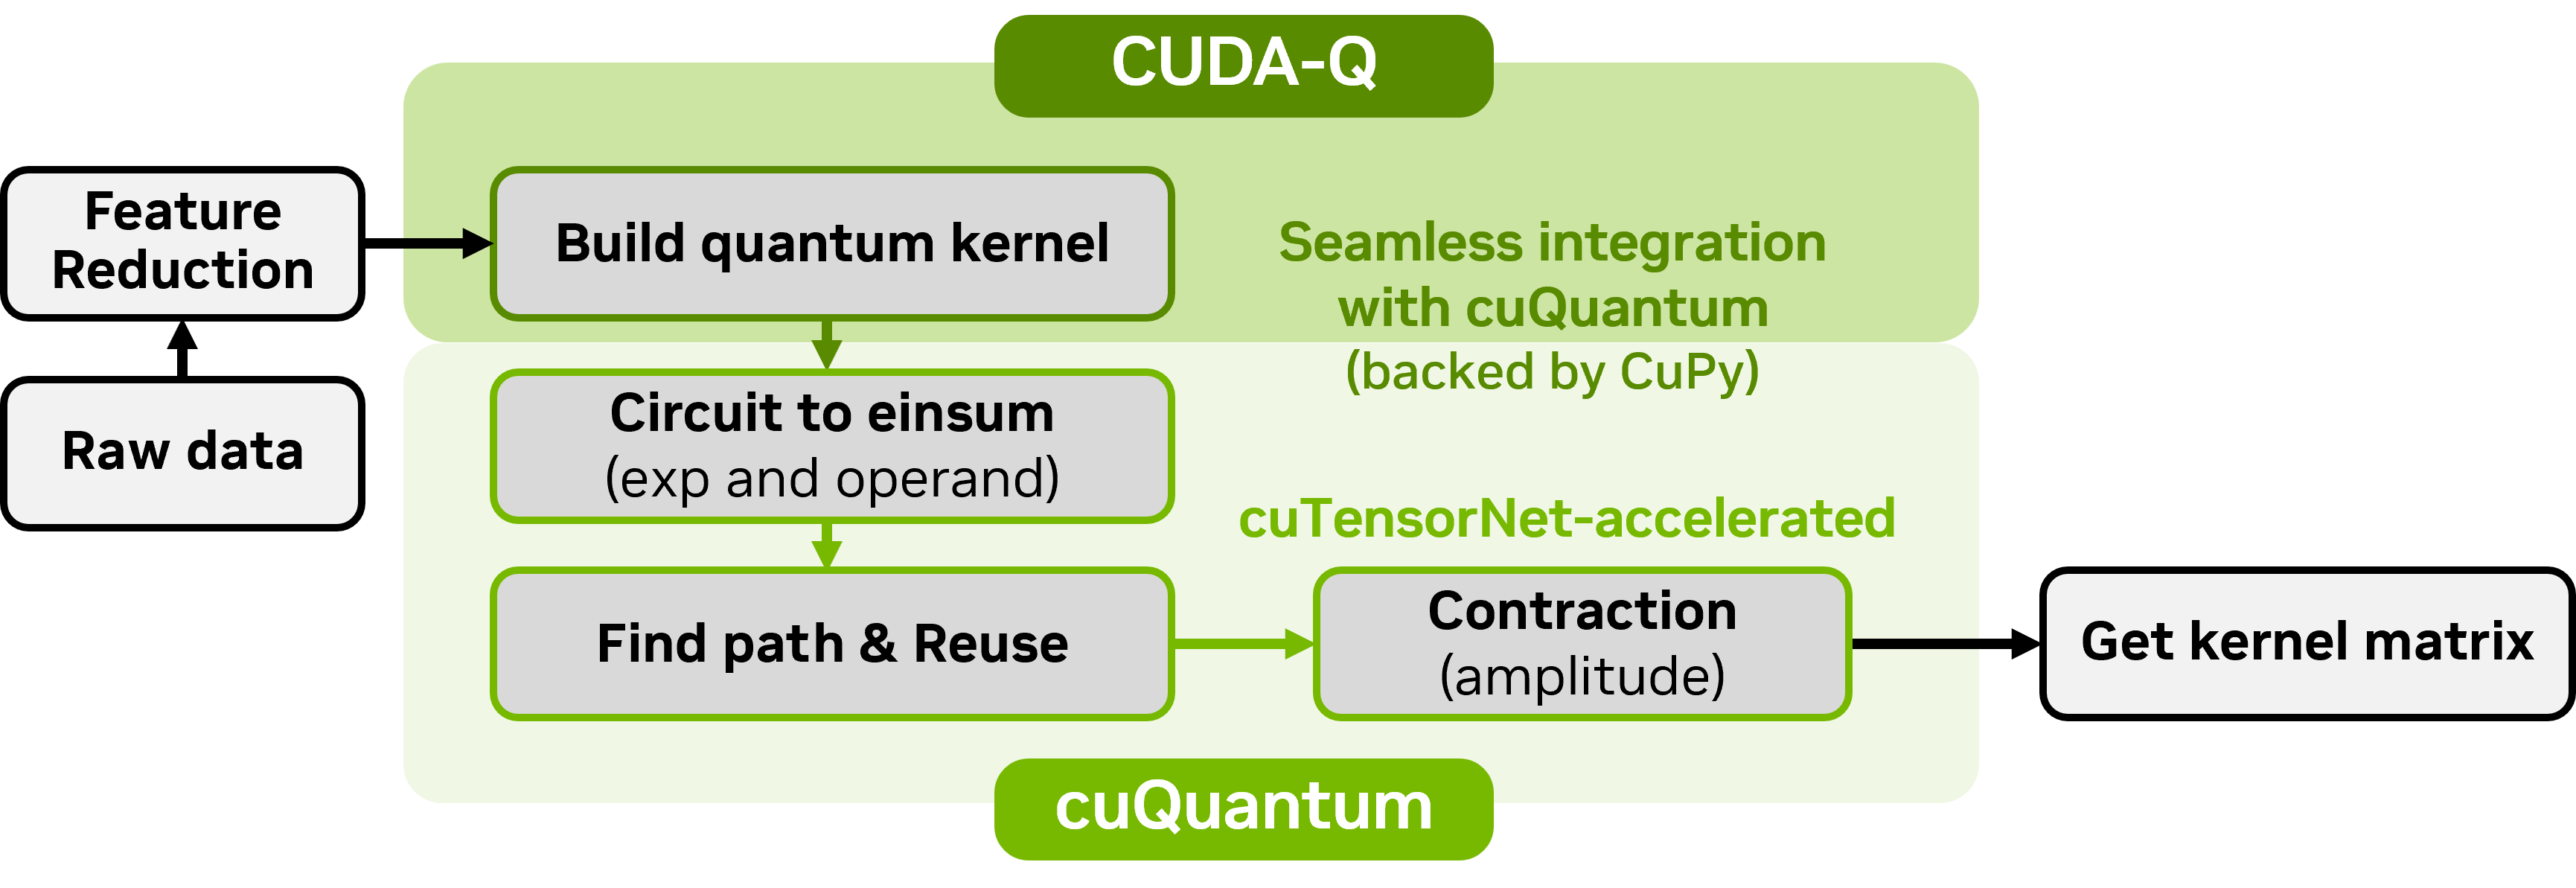

For more tchnical details, refer to this [publication](https://arxiv.org/abs/2405.02630) to learn how QSVM is accelerated by [NVIDIA Quantum](https://www.nvidia.com/en-us/solutions/quantum-computing/).

Below, we build a CUDA-Q frontend for QSVM implementation with cuQuantum, realizing end-to-end acceleration:

In [1]:
# Install the necessary packages
!pip install cuquantum-python==23.10.0
!pip install scikit-learn==1.4.2
!pip install qiskit==0.44.3
!pip install qiskit-machine-learning==0.6.1
!pip install matplotlib==3.9.2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 MB 5.2 MB/s eta 0:00:00
  Created wheel for cuquantum-python: filename=cuquantum_python-23.10.0-0_cu12-py3-none-any.whl size=6437 sha256=1605a13ea57f04e3dfde6d728612aae89c6492d0c0ef72f0ff667a6f6e203410
  Stored in directory: /root/.cache/pip/wheels/e8/2d/eb/fe0b983982cb7d50f3ac4397b05b21dfb36d12b2ad614cc7e1
Successfully built cuquantum-python
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 19.5 MB/s eta 0

In [2]:
# Import the relevant libraries
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations,product
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_openml
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from cuquantum import *

cp.cuda.set_allocator(cp.cuda.MemoryAsyncPool().malloc)

<ipython-input-2-0b706d187f4e>:17: FutureWarning: cupy.cuda.MemoryAsyncPool is experimental. The interface can change in the future.
  cp.cuda.set_allocator(cp.cuda.MemoryAsyncPool().malloc)


In [3]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used.
    Args:
        target_digits (list): digits to perform classification of
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set

    Returns:
        dataset in train, test format with targets
    """

    mnist = fetch_openml('mnist_784', as_frame=False, parser='liac-arff')
    X = mnist.data
    Y = mnist.target.astype(int)

    # Filter out the target labels.
    idx = np.where((Y == target_digits[0])|(Y == target_digits[1]))
    X,Y = X[idx],Y[idx]

     # Select a subset based on number of datapoints specified by sample_count.
    data, label = X[:sample_count],Y[:sample_count]

    return train_test_split(data, label, test_size = test_size, random_state = 255)


target_digits = [0, 1]  # Target digits to classify.
sample_count = 100  # Total number of images to use.
test_size = 0.3  # Portion of dataset to be used for testing.

X_train, X_test, Y_train, Y_test =  prepare_data(target_digits, sample_count, test_size)

print('Shape of training data:', X_train.shape)
print('Shape testing data:', X_test.shape)

Shape of training data: (70, 784)
Shape testing data: (30, 784)


In [4]:
def dim_reduction(n_dim, sample_train, sample_test):
    """Dimensionality/Feature reduction of input data using the PCA method.
    Args:
        n_dim (int): The target number of dimensions after reduction.
        sample_train (numpy.ndarray): The training data samples.
        sample_test (numpy.ndarray): The testing data samples.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: The transformed training and testing data samples.
    """

    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="full").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    return sample_train, sample_test


n_dim = 32  # Target number of dimensions for PCA, equal to the required qubit count
data_train, data_test  = dim_reduction(n_dim, X_train, X_test)

print('Shape of training data:', data_train.shape)
print('Shape of training data:', data_test.shape)

Shape of training data: (70, 32)
Shape of training data: (30, 32)


Note that for $n = 32$ qubits, the statevector method (in double precision) requires a memory capacity of $4*2^n \approx 16$ GB, which exceeds the 12 GB limit of the T4 GPU on Colab.

In [5]:
# Define quantum circuits for generating Block-Encoded State (BPS) wavefunctions of all data pairs
def make_bsp(n_dim):
    param = ParameterVector("p",n_dim)
    bsp_qc = QuantumCircuit(n_dim)
    bsp_qc.h(list(range(n_dim)))
    i = 0
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(n_dim-1):
        bsp_qc.cx(0+i, 1+i)
        i+=1
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])

    return bsp_qc

def get_circuits(y_t, x_t, indices_list, n_dim):
    bsp_qc = make_bsp(n_dim)
    bsp_kernel_tnsm = QuantumKernel(feature_map=bsp_qc)
    circuits = [bsp_kernel_tnsm.construct_circuit(y_t[i1-1], x_t[i2-1], False) for i1, i2 in tqdm(indices_list)]

    return circuits


# Index pairs list of training/testing data for kernel matrix calculation
indices_list_train = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_test  = list(product(range(1, len(data_test) + 1),range(1, len(data_train) + 1)))

# Construct all the circuits for kernel matrix calculation according to the list of index pairs
circuit_train = get_circuits(data_train, data_train, indices_list_train, n_dim)
circuit_test = get_circuits(data_test, data_train, indices_list_test, n_dim)

print("The total number of the circuits:", int(len(circuit_train) + len(circuit_test)))

100%|██████████| 2100/2100 [00:23<00:00, 88.98it/s] 

The total number of the circuits: 4515


Now interface the CUDA-Q frontend with the cuQuantum backend for efficient kernel matrix computation using tensor network simulation:

In [6]:
from multiprocessing import Pool


# Obtain the expression and operands according to the circuits
def get_info(circuit, n_dim):
    state = str(0).zfill(n_dim)
    converter = CircuitToEinsum(circuit, backend='numpy')
    exp, oper = converter.amplitude(state)

    return exp, oper


def get_oper(circuit, n_dim):
    _, oper = get_info(circuit, n_dim)

    return oper


def get_operands_parallel(circuits, n_dim, num_cpu):
    # Parallelize the code to get operands with multiprocessing
    with Pool(processes=num_cpu, maxtasksperchild=40) as pool:
        indices_list = list(range(len(circuits)))
        operands = pool.starmap(get_oper, tqdm([(circuits[i], n_dim) for i in indices_list]))

    # Conversion to CuPy
    operands_cupy = [[cp.array(oper) for oper in operands[i]] for i in tqdm(range(len(operands)))]

    return operands_cupy


# Extract the expression and operands from the circuits for subsequent tensor network contraction
exp, oper = get_info(circuit_train[0], n_dim)
operand_train = get_operands_parallel(circuit_train, n_dim, 8)
operand_test = get_operands_parallel(circuit_test, n_dim, 8)

100%|██████████| 2100/2100 [00:28<00:00, 74.73it/s]


In [7]:
def kernel_matrix_tnsm(y_t, x_t, exp, operands, indices_list, options, mode=None):
    """
    Calculate the kernel matrix using tensor network contraction accelerated by cuQuantum.

    Args:
        y_t (numpy.ndarray): The first set of input data.
        x_t (numpy.ndarray): The second set of input data.
        exp (str): The tensor network expression.
        operands (list): List of tensors.
        indices_list (list): List of index pairs for kernel matrix calculation.
        options (class): Options specified by cuquantum.NetworkOptions for the tensor network.
        mode (str, optional): If 'train', the function will make the kernel matrix symmetric and add a diagonal of ones.

    Returns:
        np.ndarray: The computed kernel matrix.
    """

    kernel_matrix = cp.zeros((len(y_t),len(x_t)))
    i, oper = -1, operands[0]
    with Network(exp, *oper, options=options) as tn:
        tn.contract_path()
        for i1, i2 in tqdm(indices_list):
            i += 1
            tn.reset_operands(*operands[i])
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1-1][i2-1] = cp.round(amp_tn,8)
        tn.free()
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(cp.ones((len(x_t))))

    return kernel_matrix.get()


# Define the tensor network contraction details with specified operand, options, path, and info
options = NetworkOptions(blocking="auto")
network = Network(exp, *oper, options=options)
path, info = network.contract_path()
network.autotune(iterations=20)


# Compute the kernel matrix for training and testing data
tnsm_kernel_matrix_train = kernel_matrix_tnsm(data_train, data_train, exp, operand_train, indices_list_train, options, mode='train')
tnsm_kernel_matrix_test  = kernel_matrix_tnsm(data_test, data_train, exp, operand_test, indices_list_test, options, mode=None)

100%|██████████| 2100/2100 [00:16<00:00, 125.85it/s]


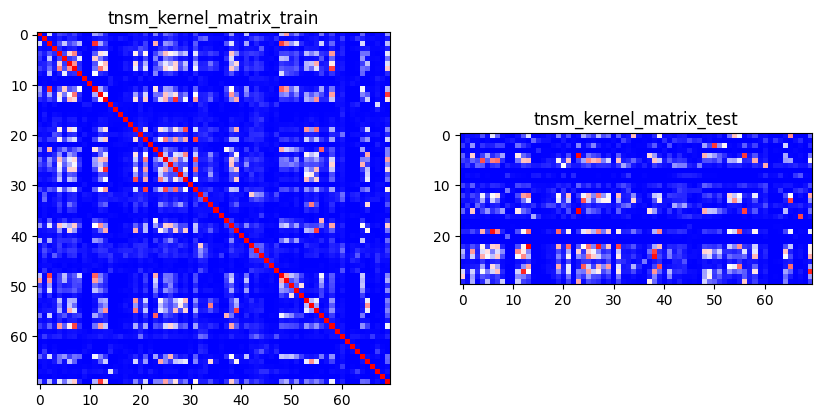

In [8]:
# Visialize the kernel matrix

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(tnsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("tnsm_kernel_matrix_train")
axs[1].imshow(np.asmatrix(tnsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("tnsm_kernel_matrix_test")
plt.show()

In [9]:
# Use the precomputed kernel matrix for the subsequent support vector classifier

svc = SVC(kernel="precomputed")
svc.fit(tnsm_kernel_matrix_train,Y_train)
acc_train = svc.score(tnsm_kernel_matrix_train,Y_train)
acc_test = svc.score(tnsm_kernel_matrix_test,Y_test)
print("The training accuracy = ", round(acc_train*100, 3), "(%)")
print("The testing accuracy = ", round(acc_test*100, 3), "(%)")

The training accuracy =  100.0 (%)
The testing accuracy =  93.333 (%)
